In [124]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.special import boxcox1p
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
import math
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [177]:
features = pd.read_csv('features.csv')
train = pd.read_csv('Sales.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

In [178]:
init_merge = features.merge(stores, how='inner', on='Store')

In [179]:
pd.DataFrame(init_merge.dtypes, columns=['Type'])

,Type
Store,int64
Date,object
Temperature,float64
Fuel_Price,float64
MarkDown1,float64
MarkDown2,float64
MarkDown3,float64
MarkDown4,float64
MarkDown5,float64
CPI,float64


In [128]:
init_merge.Date = pd.to_datetime(init_merge.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

In [129]:
init_merge['Week'] = init_merge.Date.dt.week 
init_merge['Year'] = init_merge.Date.dt.year

In [130]:
feat_deet = train.merge(init_merge, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [131]:
test_detail = test.merge(init_merge, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [132]:
del features, train, stores, test

In [133]:
#checking full Data for null columns
null_columns = (feat_deet.isnull().sum(axis = 0)/len(feat_deet)).sort_values(ascending=False).index
null_data = pd.concat([
    feat_deet.isnull().sum(axis = 0),
    (feat_deet.isnull().sum(axis = 0)/len(feat_deet)).sort_values(ascending=False),
    feat_deet.loc[:, feat_deet.columns.isin(list(null_columns))].dtypes], axis=1)
null_data = null_data.rename(columns={0: '# null', 
                                      1: '% null', 
                                      2: 'type'}).sort_values(ascending=False, by = '% null')
null_data = null_data[null_data["# null"]!=0]
null_data
#here we find that each of the mark downs has more than 60% null values, so we are going to drop these columns 

,# null,% null,type
MarkDown2,310322,0.736110,float64
MarkDown4,286603,0.679847,float64
MarkDown3,284479,0.674808,float64
MarkDown1,270889,0.642572,float64
MarkDown5,270138,0.640790,float64


In [134]:
pysqldf("""
SELECT
    T.*,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Super Bowl'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Labor Day'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thanksgiving'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 then 'Christmas'
    end as Holyday,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Monday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thursday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2010 then 'Saturday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2011 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2012 then 'Tuesday'
    end as Day
    from(
        SELECT DISTINCT
            Year,
            Week,
            case 
                when Date <= '2012-11-01' then 'Train Data' else 'Test Data' 
            end as Data_type
        FROM init_merge
        WHERE IsHoliday = True) as T""")

,Year,Week,Data_type,Holyday,Day
0,2010,6,Train Data,Super Bowl,Sunday
1,2010,36,Train Data,Labor Day,Monday
2,2010,47,Train Data,Thanksgiving,Thursday
3,2010,52,Train Data,Christmas,Saturday
4,2011,6,Train Data,Super Bowl,Sunday
5,2011,36,Train Data,Labor Day,Monday
6,2011,47,Train Data,Thanksgiving,Thursday
7,2011,52,Train Data,Christmas,Sunday
8,2012,6,Train Data,Super Bowl,Sunday
9,2012,36,Train Data,Labor Day,Monday


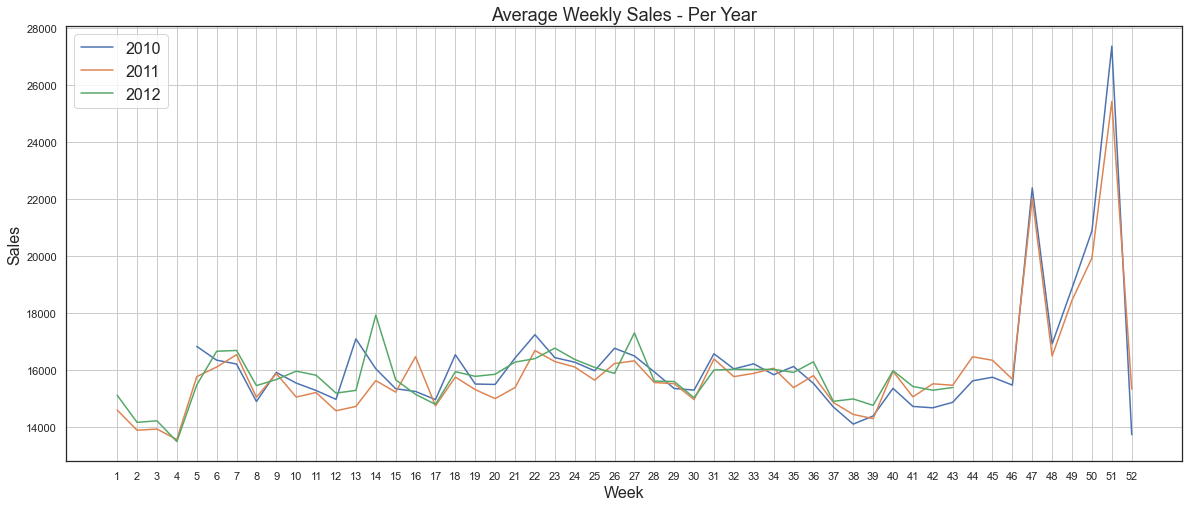

In [135]:
weekly_sales_2010 = feat_deet[feat_deet.Year==2010]['Weekly_Sales'].groupby(feat_deet['Week']).mean()
weekly_sales_2011 = feat_deet[feat_deet.Year==2011]['Weekly_Sales'].groupby(feat_deet['Week']).mean()
weekly_sales_2012 = feat_deet[feat_deet.Year==2012]['Weekly_Sales'].groupby(feat_deet['Week']).mean()

plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

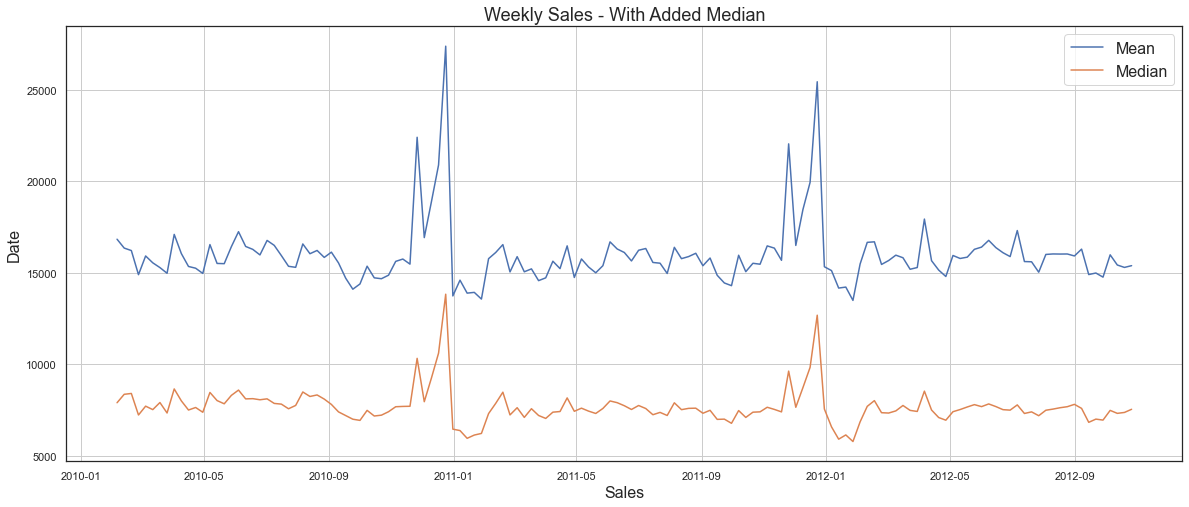

In [136]:
feat_deet.loc[(feat_deet.Year==2010) & (feat_deet.Week==13), 'IsHoliday'] = True
feat_deet.loc[(feat_deet.Year==2011) & (feat_deet.Week==16), 'IsHoliday'] = True
feat_deet.loc[(feat_deet.Year==2012) & (feat_deet.Week==14), 'IsHoliday'] = True
test_detail.loc[(test_detail.Year==2013) & (test_detail.Week==13), 'IsHoliday'] = True

weekly_sales_mean = feat_deet['Weekly_Sales'].groupby(feat_deet['Date']).mean()
weekly_sales_median = feat_deet['Weekly_Sales'].groupby(feat_deet['Date']).median()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)
plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - With Added Median', fontsize=18)
plt.xlabel('Sales', fontsize=16)
plt.ylabel('Date', fontsize=16)
plt.show()


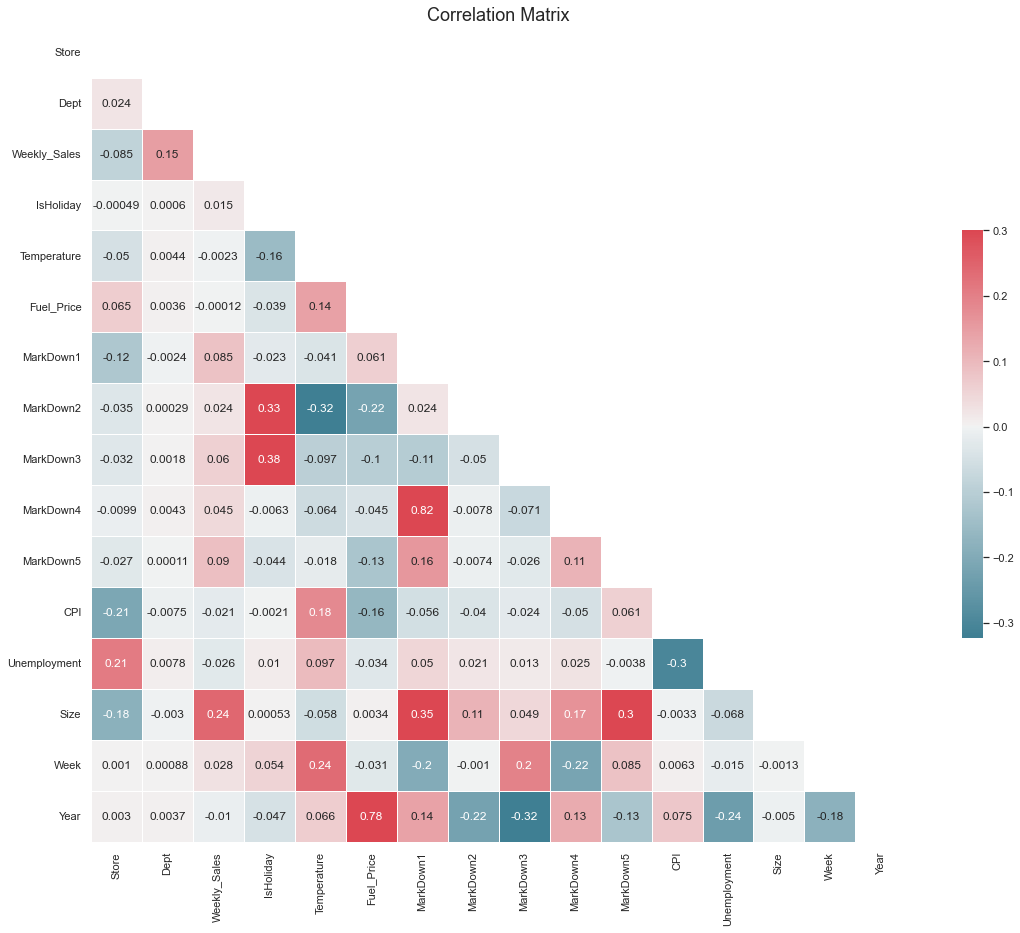

In [137]:
sns.set(style="white")

corr = feat_deet.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

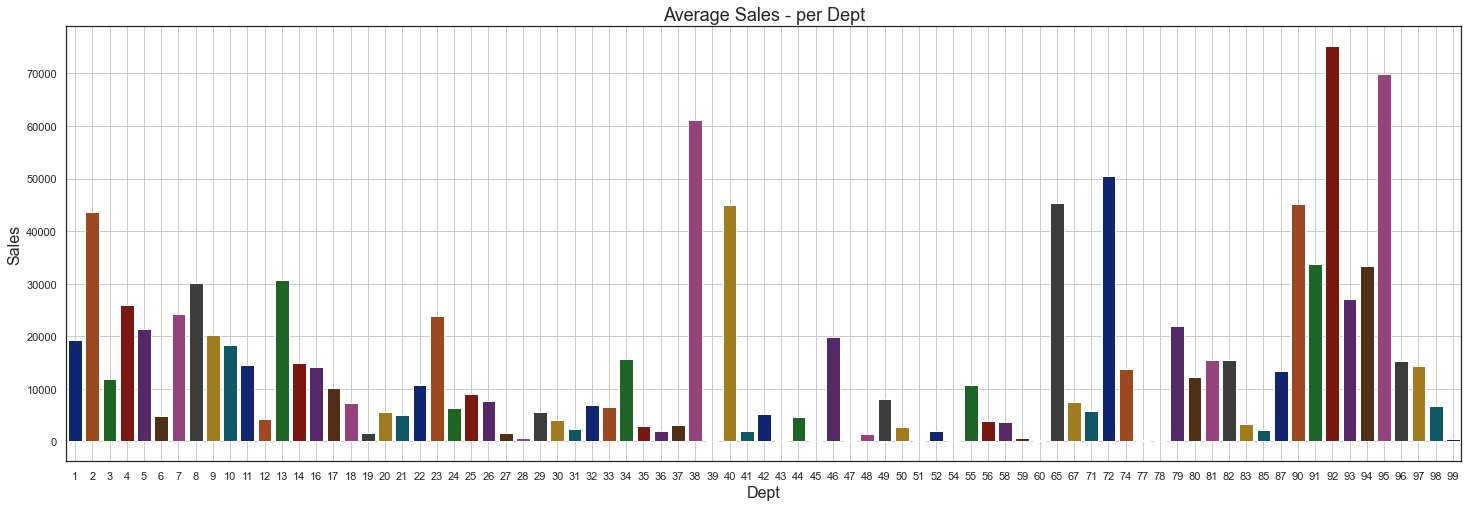

In [138]:
weekly_sales = feat_deet['Weekly_Sales'].groupby(feat_deet['Dept']).mean()
plt.figure(figsize=(25,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

In [153]:
# feat_deet = feat_deet.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
# test_detail = test_deatil.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])

KeyError: "['Fuel_Price' 'MarkDown1' 'MarkDown2' 'MarkDown3' 'MarkDown4' 'MarkDown5'] not found in axis"

In [ ]:
# feat_deet = feat_deet.drop(columns=['Temperature','CPI','Unemployment'])
# test_detail = test_detail.drop(columns=['Temperature','CPI','Unemployment'])

In [168]:
feat_deet.Type = feat_deet.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))
test_detail.Type = test_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))

feat_deet['Type'] = feat_deet['Type'].astype(float)


,Type
Store,int64
Dept,int64
Date,datetime64[ns]
Weekly_Sales,float64
IsHoliday,bool
Temperature,float64
CPI,float64
Unemployment,float64
Type,float64
Size,int64


In [155]:
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

In [156]:
def random_forest(n_estimators, max_depth):
    result = []
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Max_Depth': depth, 'Estimators': estimator, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [157]:
def random_forest_II(n_estimators, max_depth, max_features):
    result = []
    for feature in max_features:
        wmaes_cv = []
        for i in range(1,5):
            print('k:', i, ', max_features:', feature)
            x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
            RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=feature)
            RF.fit(x_train, y_train)
            predicted = RF.predict(x_test)
            wmaes_cv.append(WMAE(x_test, y_test, predicted))
        print('WMAE:', np.mean(wmaes_cv))
        result.append({'Max_Feature': feature, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [158]:
def random_forest_III(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):
    result = []
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', min_samples_split:', split, ', min_samples_leaf:', leaf)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, 
                                           min_samples_leaf=leaf, min_samples_split=split)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Min_Samples_Leaf': leaf, 'Min_Samples_Split': split, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [159]:
X_train = feat_deet[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
Y_train = feat_deet['Weekly_Sales']


        Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  \
0           1     1 2010-02-05      24924.50      False        42.31   
1           1     1 2010-02-12      46039.49       True        38.51   
2           1     1 2010-02-19      41595.55      False        39.93   
3           1     1 2010-02-26      19403.54      False        46.63   
4           1     1 2010-03-05      21827.90      False        46.50   
...       ...   ...        ...           ...        ...          ...   
421565     45    98 2012-09-28        508.37      False        64.88   
421566     45    98 2012-10-05        628.10      False        64.89   
421567     45    98 2012-10-12       1061.02      False        54.47   
421568     45    98 2012-10-19        760.01      False        56.47   
421569     45    98 2012-10-26       1076.80      False        58.85   

               CPI  Unemployment  Type    Size  Week  Year  
0       211.096358         8.106     1  151315     5  2010  
1       211.2

In [160]:
# n_estimators = [56, 58, 60]
# max_depth = [25, 27, 30]

# random_forest(n_estimators, max_depth)

In [161]:
# max_features = [2, 3, 4, 5, 6, 7]

# random_forest_II(n_estimators=58, max_depth=27, max_features=max_features)

In [162]:
# min_samples_split = [2, 3, 4]
# min_samples_leaf = [1, 2, 3]

# random_forest_III(n_estimators=58, max_depth=27, max_features=6, 
#                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

In [163]:
RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=6, min_samples_split=3, min_samples_leaf=1)
RF.fit(X_train, Y_train)

RandomForestRegressor(max_depth=27, max_features=6, min_samples_split=3,
                      n_estimators=58)

In [169]:
X_test = test_detail[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
predict = RF.predict(X_test)
print(predict)

[31553.96846839 19315.17822783 19326.63829967 ...   702.14885632
   741.45049425   683.72043103]


In [170]:
Final = X_test[['Store', 'Dept', 'Week']]
Final['Weekly_Sales'] = predict

In [180]:
Christmas = pysqldf("""
    SELECT
        Store,
        Dept,
        Week,
        Weekly_Sales,
        case 
            when Week = 52 and last_sales > 2*Weekly_Sales then Weekly_Sales+(2.5/7)*last_sales
            else Weekly_Sales 
        end as Weekly_Sales_Adjusted
    from(
        SELECT
            Store, 
            Dept, 
            Week, 
            Weekly_Sales,
            case 
                when Week = 52 then lag(Weekly_Sales) over(partition by Store, Dept) 
            end as last_sales
        from Final)""")

In [181]:
# #Uploading predicted results to final csv file
submission['Weekly_Sales'] = Christmas['Weekly_Sales_Adjusted']
submission.to_csv('submission.csv',index=False)
